In [1]:
# Sofia Garcia slg2183 
# Karolina Majewska kam2357
# Samir Sanchez ses2313

#Single Cell Segmentation

#References AOE BME Lecture 4 Part C directly
import os
import glob

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
torch.manual_seed(1102)
np.random.seed(1102)
import tensorflow.keras.datasets.mnist as MNIST

cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
#References AOE BME Lecture 4 Part C directly
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/train/image/image_*.png | wc -l
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/valid/image/image_*.png | wc -l
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/test/image/image_*.png | wc -l

4140
1380
2070


In [3]:
#References AOE BME Lecture 4 Part C directly
data_root_folder = '../input/singlecellsegmentation/SingleCellSegmentation/'
class Dataset(TensorDataset):
    #Takes the folders name as the input makes a BasicDataset 
    def __init__(self, folder, n_sample=None):
        self.folder = os.path.join(data_root_folder, folder)
        self.imgs_dir = os.path.join(self.folder, 'image')
        self.masks_dir = os.path.join(self.folder, 'mask')
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.png')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*.png')))
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
            
    #Function returns the length of the dataset
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        img = cv2.imread(os.path.join(self.imgs_dir, 'image_{0:04d}.png'.format(idx)), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_dir, 'mask_{0:04d}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Resize all images from 512 to 256 (H and W)
        img = cv2.resize(img, (256,256))
        mask = cv2.resize(mask, (256,256))
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0.0
        mask[mask > 0.5] = 1.0
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        mask = np.expand_dims(mask, axis=0)
        
        # HWC to CHW
        img = np.transpose(img, (2, 0, 1))
        
        
        
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': idx
        }

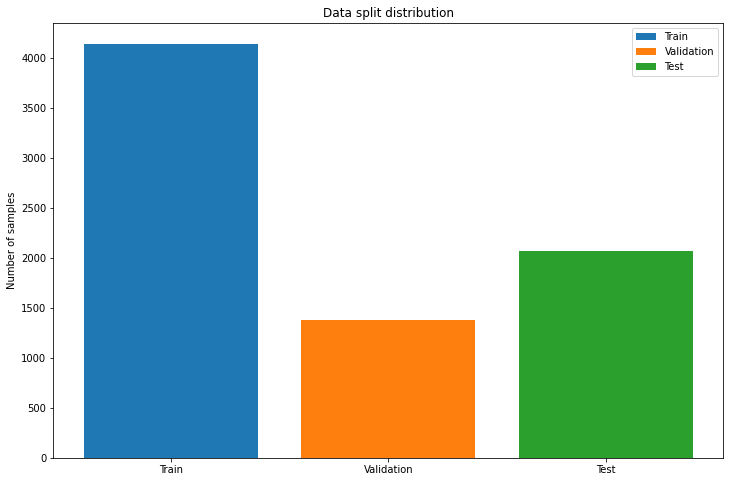

In [4]:
#References AOE BME Lecture 4 Part C directly
train_set = Dataset('train')
valid_set = Dataset('valid')
test_set = Dataset('test')

plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_set), label='Train')
plt.bar(1, len(valid_set), label='Validation')
plt.bar(2, len(test_set), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

x shape is torch.Size([3, 256, 256])
y shape is torch.Size([1, 256, 256])


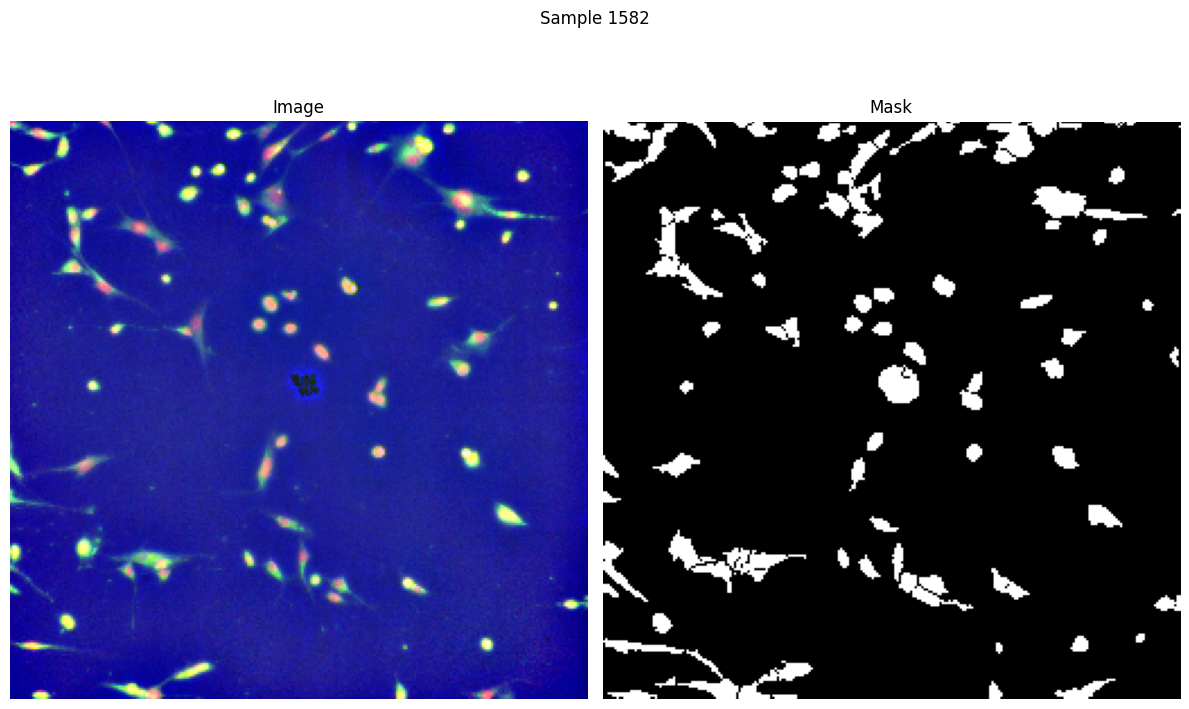

In [5]:
#References AOE BME Lecture 4 Part C directly
train_set = Dataset('train')
valid_set = Dataset('valid')
test_set = Dataset('test')

sample = np.random.randint(0, len(train_set))
data = train_set.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx:04d}')
img = np.transpose(x, (1,2,0))
mask = y[0]
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()



train_dloader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
valid_dloader = DataLoader(valid_set, batch_size=4, num_workers=2, pin_memory=True)
test_dloader = DataLoader(test_set, batch_size=4, num_workers=2, pin_memory=True)

In [6]:
#References AOE BME Lecture 4 Part C directly
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = Dataset('train', n_sample=1000)
valid_dataset = Dataset('valid', n_sample=200)
test_dataset = Dataset('test', n_sample=200)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=2, pin_memory=True)

In [7]:
#References AOE BME Lecture 4 Part C directly
# double convolution
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x
    
# output layer 
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

In [8]:
#References AOE BME Lecture 4 Part C directly
class UNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
        
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        b = self.down4(x4)
        
        x = self.up1(b, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

In [9]:
#Directly from AOE BME Lecture4_PartC UNet Example
my_unet = UNet('MyUNet', 3, 1)
my_unet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

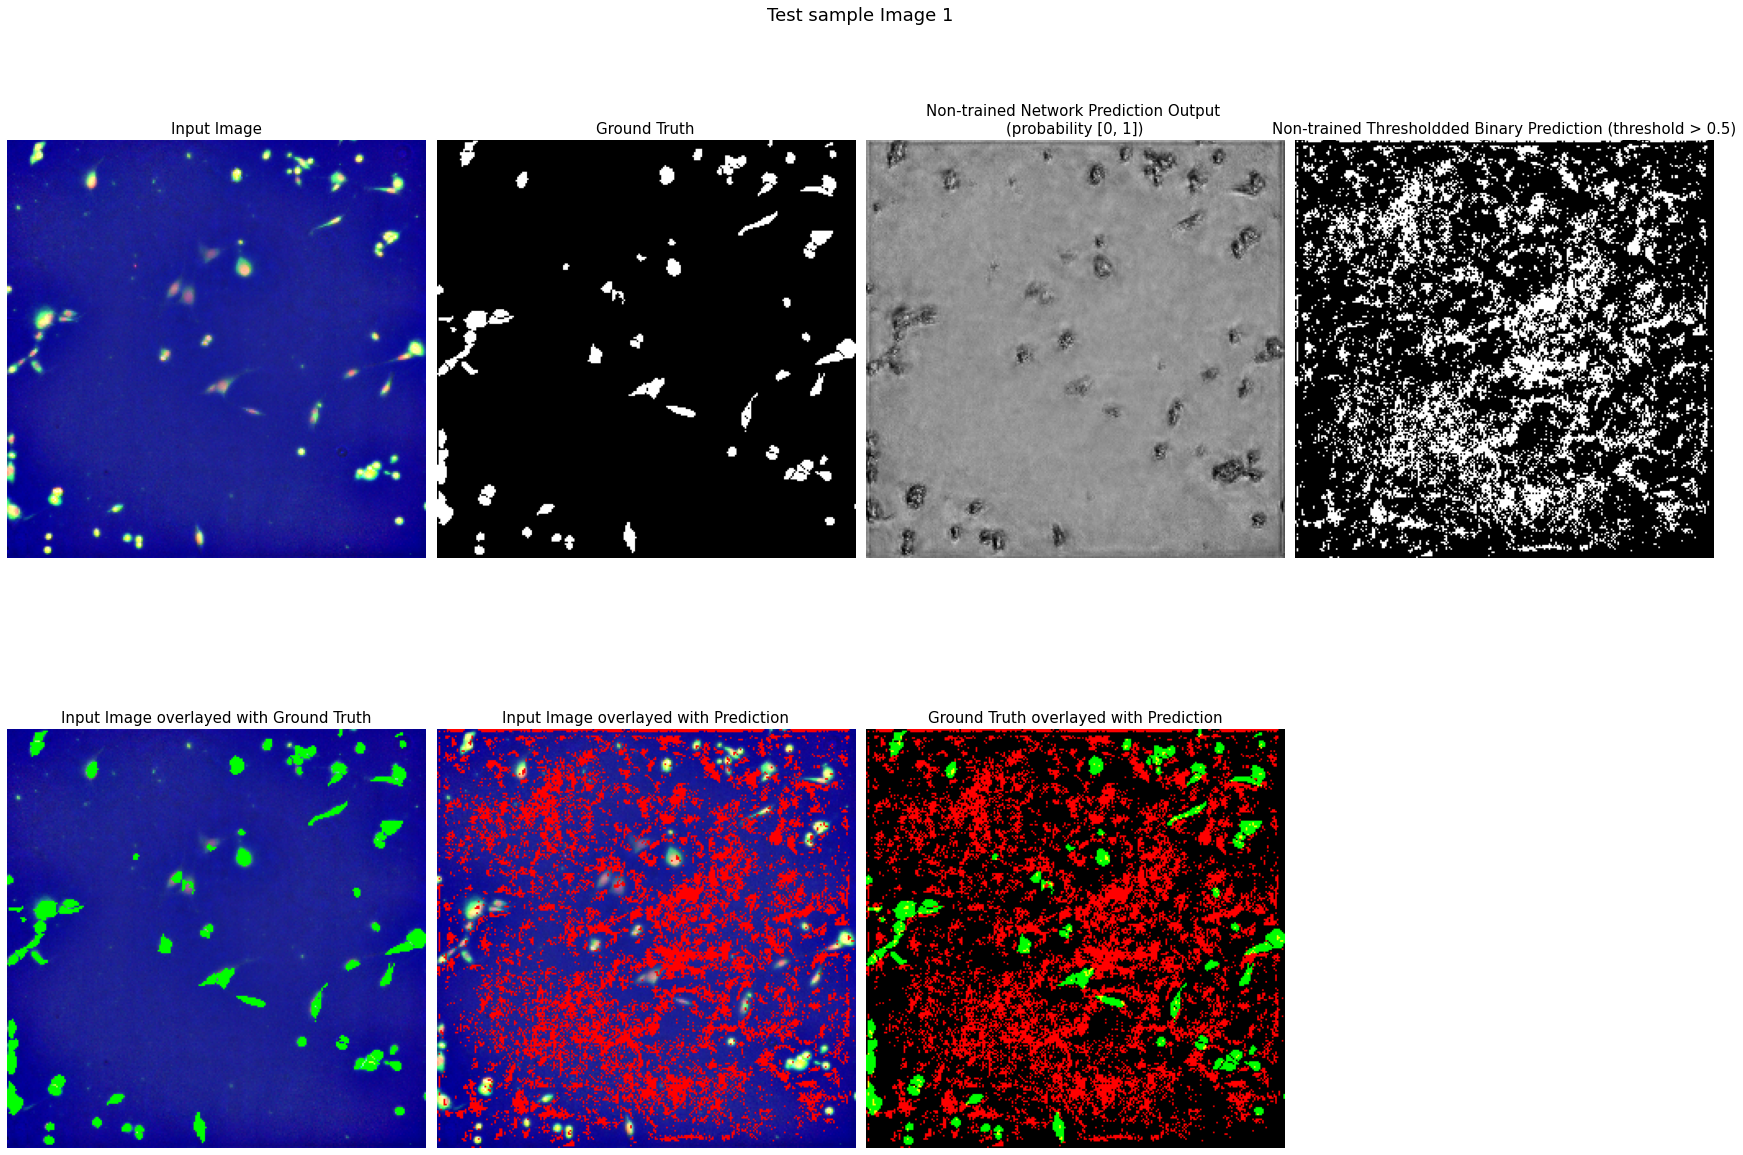

In [10]:
#Directly from AOE BME Lecture4_PartC UNet Example
#Takes the batch, get's the network's output then plots it
for batch in test_dloader:
    sample_batch = batch
    break
    
    
with torch.no_grad():
    y_pred = my_unet(sample_batch['image'].cuda())
          
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')


pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,3)
plt.title('Non-trained Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,4)
plt.title('Non-trained Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
#References AOE BME Lecture 4 Part C directly
optimizer = torch.optim.Adam(my_unet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [12]:
#References AOE BME Lecture 4 Part C directly
#Directly from AOE BME Lecture4_PartC_UNetExample
def dice_coeff_binary(y_pred, y_true):
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1), y_true.view(-1))
        union = torch.sum(y_pred) + torch.sum(y_true)
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()
    

# training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            y_pred = net(imgs)

            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)


            pred_binary = (y_pred > 0.5).float()
            
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
      # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                
                
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')

        ################################################################################################################################
        ###################################################### Saving Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, valid_loss, valid_dice

In [13]:
#References AOE BME Lecture 4 Part C directly
EPOCHS = 50
train_loss, train_dice, valid_loss, valid_dice = train_net(my_unet, EPOCHS, train_dloader, valid_dloader, optimizer, loss_function)

KeyboardInterrupt: 

In [ ]:
#References AOE BME Lecture 4 Part C directly
plt.figure(figsize=(15,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#References AOE BME Lecture 4 Part C directly
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

my_unet.load_state_dict(state_dict)
my_unet.cuda()

In [ ]:
#References AOE BME Lecture 4 Part C directly
# Take the first batch
for batch in test_dloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_unet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape 
                                                                                                                      ))
# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#References AOE BME Lecture 4 Part C directly
def test_net(net, test_dloader, loss_function):
    # Create the pred_mask folder
    if not os.path.isdir('/kaggle/working/pred_mask'):
        os.mkdir('/kaggle/working/pred_mask')
    
    net.eval()
    
    n_test = len(test_dloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)
            
            
            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Save the predicted masks
            for idx, pred_msk in enumerate(pred_binary):
                cv2.imwrite(f'/kaggle/working/pred_mask/pred_mask_{img_ids[idx]:04}.png', np.expand_dims((pred_msk[0].cpu().numpy() * 255).astype('uint8'), axis=-1))
                
          
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)


            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Accuracy: {batch_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_accuracy, test_CM

In [ ]:
#References AOE BME Lecture 4 Part C directly
test_loss, test_dice, test_accuracy, test_CM = test_net(my_unet, test_dloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')

In [ ]:
#References AOE BME Lecture 4 Part C directly
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');